<a href="https://colab.research.google.com/github/charlesHsuGG/whale_tail_detection/blob/master/Saimese_Xception_for_whale_tail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow
from matplotlib.pyplot import imshow

<!--  新增代碼註解-->
**安裝最新版本kaggle,並且加入token文件以便匯入kaggle dataset**

---

1.   取得類別數量
2.   建立雙頭巨魔網路
3.   比較網路相似度
4.   進行top5 分類排序

#####02/23 提高dropout 至0.5 減少過擬和######



In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c humpback-whale-identification

  0% 0.00/498k [00:00<?, ?B/s]
100% 498k/498k [00:00<00:00, 68.5MB/s]
  0% 0.00/594k [00:00<?, ?B/s]
100% 594k/594k [00:00<00:00, 38.2MB/s]
100% 1.35G/1.35G [00:19<00:00, 86.6MB/s]

100% 4.14G/4.16G [00:59<00:00, 68.5MB/s]
100% 4.16G/4.16G [00:59<00:00, 75.5MB/s]


In [ ]:
!mkdir /content/train
!mkdir /content/test

In [ ]:
%cd /content/train
import zipfile
zip_ref = zipfile.ZipFile('/content/train.zip', "r")
zip_ref.extractall()
zip_ref.close()

/content/train


In [ ]:
%cd /content/test
zip_ref = zipfile.ZipFile('/content/test.zip', "r")
zip_ref.extractall()
zip_ref.close()

/content/test


In [ ]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("/content"))

['.config', 'train', 'train.zip', 'kaggle.json', 'train.csv', 'test', 'test.zip', 'sample_submission.csv', 'sample_data']


In [ ]:
# set data path and read df
image_path = '/content/train/'
train_df = pd.read_csv("/content/train.csv")
train_df = train_df.query('Id != "new_whale"')

In [ ]:
images = [whale_img for whale_img in train_df["Image"]]
labels = [whale_label for whale_label in train_df["Id"]]

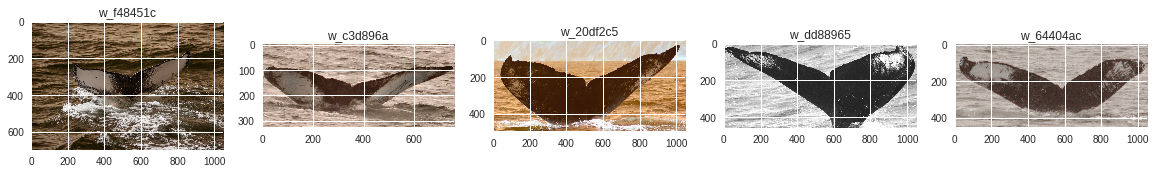

In [ ]:
fig, axs = plt.subplots(1, len(images[:5]), figsize = (20, 10))
for ii, c_ax in enumerate(axs):
    c_ax.imshow(cv2.imread(os.path.join(image_path,images[ii])))
    c_ax.set_title(labels[ii])

In [ ]:
print(len(images))

15697


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
y_train = np.array(labels)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
y_train  = onehot_encoded

print(y_train.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(15697, 5004)


In [ ]:
print(y_train.shape)

(15697, 5004)


In [ ]:
num_classes = y_train.shape[1]
img_rows, img_cols, img_channels = 299, 299, 3
input_shape = (img_rows, img_cols, img_channels)
print(num_classes)
print(input_shape)

5004
(299, 299, 3)


In [ ]:
from keras.models import Model
from keras.layers import *
from keras.applications import *

base_model_1 = Xception(input_shape=(299, 299, 3), weights='imagenet', include_top=True)
base_model_2 = Xception(input_shape=(299, 299, 3), weights='imagenet', include_top=True)

for layer in base_model_1.layers:
    layer.trainable = False
    layer.name = layer.name + "_1"
for layer in base_model_2.layers:
    layer.trainable = False
    layer.name = layer.name + "_2"

base_model_1.summary()

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_1 (InputLayer)          (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1_1 (Conv2D)         (None, 149, 149, 32) 864         input_1_1[0][0]                  
__________________________________________________________________________________________________
block1_conv1_bn_1 (BatchNormali (None, 149, 149, 32) 128         block1_conv1_1[0][0]             
__________________________________________________________________________________________________
block1_conv1_act_1 (Activation) (None, 149, 149, 32) 0           block1_conv1_bn_1[0][0]          
__________________________________________________________________________________________________
block1_con

In [ ]:
from keras import backend as K
from keras.layers.core import Activation, Dense, Dropout, Lambda
import os

v1 = base_model_1.get_layer("avg_pool_1").output
v2 = base_model_2.get_layer("avg_pool_2").output

In [ ]:
def cosine_distance(vecs, normalize=False):
    x, y = vecs
    if normalize:
        x = K.l2_normalize(x, axis=0)
        y = K.l2_normalize(x, axis=0)
    return K.prod(K.stack([x, y], axis=1), axis=1)

In [ ]:
def cosine_distance_output_shape(shapes):
    return shapes[0]

In [ ]:
def sim_model(v1, v2):

    print('v1', v1)
    print('v2', v2)

    distance = Lambda(cosine_distance,
                    output_shape=cosine_distance_output_shape)([v1, v2])
    print('distance', distance)
#     fc1 = Dense(512, kernel_initializer="glorot_uniform")(distance)
#     fc1 = Dropout(0.2)(fc1)
#     fc1 = Activation("relu")(fc1)

    fc2 = Dense(128, kernel_initializer="glorot_uniform")(distance)
    fc2 = Dropout(0.2)(fc2)
    fc2 = Activation("relu")(fc2)

    pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
    pred = Activation("softmax")(pred)
    print('pred', pred)
    return pred

In [ ]:
pred = sim_model(v1, v2)

v1 Tensor("avg_pool/Mean:0", shape=(?, 2048), dtype=float32)
v2 Tensor("avg_pool_1/Mean:0", shape=(?, 2048), dtype=float32)
distance Tensor("lambda_1/Prod:0", shape=(?, 2048), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
pred Tensor("activation_2/Softmax:0", shape=(?, 2), dtype=float32)


In [ ]:
model = Model(inputs=[base_model_1.input, base_model_2.input], outputs=pred)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_1 (InputLayer)          (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
input_2_2 (InputLayer)          (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1_1 (Conv2D)         (None, 149, 149, 32) 864         input_1_1[0][0]                  
__________________________________________________________________________________________________
block1_conv1_2 (Conv2D)         (None, 149, 149, 32) 864         input_2_2[0][0]                  
__________________________________________________________________________________________________
block1_con

In [ ]:
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks_list = [
        EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=3, verbose=0, mode='auto', epsilon=0.0001,
                            cooldown=0, min_lr=0)
    ]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [ ]:
import itertools
from keras.utils import np_utils

def create_image_triples_from_dataframe(df):
    image_groups = {}
    for index, row in df.iterrows():
        image_name = row['Image']
        whale_label = row['Id']
        if whale_label in image_groups.keys():
            image_groups[whale_label].append(image_name)
        else:
            image_groups[whale_label] = [image_name]
    num_sims = 0
    image_triples = []
    group_list = sorted(list(image_groups.keys()))
    for i, g in enumerate(group_list):
        if num_sims % 100 == 0:
            print("Generated {:d} pos + {:d} neg = {:d} total image triples"
                  .format(num_sims, num_sims, 2*num_sims))
        images_in_group = image_groups[g]
        sim_pairs_it = itertools.combinations(images_in_group, 2)
        # for each similar pair, generate a corresponding different pair
        for ref_image, sim_image in sim_pairs_it:
            image_triples.append((ref_image, sim_image, 1))
            num_sims += 1
            while True:
                j = np.random.randint(low=0, high=len(group_list), size=1)[0]
                if j != i:
                    break
            dif_image_candidates = image_groups[group_list[j]]
            k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
            dif_image = dif_image_candidates[k]
            image_triples.append((ref_image, dif_image, 0))
    print("Generated {:d} pos + {:d} neg = {:d} total image triples"
          .format(num_sims, num_sims, 2*num_sims))
    return image_triples


In [ ]:
print('Creating triples...')
triples = create_image_triples_from_dataframe(train_df)

Creating triples...
Generated 0 pos + 0 neg = 0 total image triples
Generated 0 pos + 0 neg = 0 total image triples
Generated 0 pos + 0 neg = 0 total image triples
Generated 5300 pos + 5300 neg = 10600 total image triples
Generated 5400 pos + 5400 neg = 10800 total image triples
Generated 5400 pos + 5400 neg = 10800 total image triples
Generated 5500 pos + 5500 neg = 11000 total image triples
Generated 6100 pos + 6100 neg = 12200 total image triples
Generated 13400 pos + 13400 neg = 26800 total image triples
Generated 13400 pos + 13400 neg = 26800 total image triples
Generated 13400 pos + 13400 neg = 26800 total image triples
Generated 13500 pos + 13500 neg = 27000 total image triples
Generated 15300 pos + 15300 neg = 30600 total image triples
Generated 15500 pos + 15500 neg = 31000 total image triples
Generated 15500 pos + 15500 neg = 31000 total image triples
Generated 17700 pos + 17700 neg = 35400 total image triples
Generated 26600 pos + 26600 neg = 53200 total image triples
Genera

In [ ]:
from scipy.misc import imresize
def load_image(image_dir, image_name, image_size):
    image = cv2.imread(os.path.join(image_dir, image_name), 0).astype(np.float32)
    image = imresize(image, (image_size, image_size))
    image = np.divide(image, 256)
    image = cv2.merge((image,image,image))
    return image

In [ ]:
def load_image_label_with_batch(image_dir, shuffled_triples_batch, image_size):
    labels = []
    lhs_images = []
    rhs_images = []
    for i in range(len(shuffled_triples_batch)):
        lhs, rhs, label = shuffled_triples_batch[i]
        lhs = load_image(image_dir, lhs, image_size)
        rhs = load_image(image_dir, rhs, image_size)
        lhs_images.append(lhs)
        rhs_images.append(rhs)
        labels.append(label)
    lhs_images = (np.array(lhs_images))
    rhs_images = (np.array(rhs_images))
    Y = np_utils.to_categorical(np.array(labels), num_classes=2)
#     Y = (np.array(labels))
    return ([lhs_images, rhs_images], Y)

In [ ]:
def load_image_triplets(image_dir, image_triples, image_size, batch_size, shuffle=False):
    while True:
        # loop once per epoch
        if shuffle:
            indices = np.random.permutation(np.arange(len(image_triples)))
        else:
            indices = np.arange(len(image_triples))
        shuffled_triples = [image_triples[ix] for ix in indices]
        num_batches = len(shuffled_triples) // batch_size
        for bid in range(num_batches):
            # loop once per batch
            batch = shuffled_triples[bid * batch_size : (bid + 1) * batch_size]

            X, Y = load_image_label_with_batch(image_dir, batch, image_size)

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

In [ ]:
from sklearn.model_selection import train_test_split
X_triples_train, X_triples_val = train_test_split(triples, test_size=0.33, random_state=7)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64
history = model.fit_generator(load_image_triplets(image_path, X_triples_train, 299, BATCH_SIZE, shuffle=False),
                                  steps_per_epoch = len(X_triples_train) // BATCH_SIZE,
                                  validation_data=load_image_triplets(image_path, X_triples_val, 299, BATCH_SIZE, shuffle=False),
                                  validation_steps= len(X_triples_val) // BATCH_SIZE,
                                  epochs=EPOCHS, verbose=1, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


1464/1464 [==============================] - 5584s 4s/step - loss: 0.5432 - acc: 0.7209 - val_loss: 0.9017 - val_acc: 0.5587
Epoch 2/10
1464/1464 [==============================] - 5594s 4s/step - loss: 0.4520 - acc: 0.7852 - val_loss: 0.8802 - val_acc: 0.5841
Epoch 3/10
 149/1464 [==>...........................] - ETA: 54:34 - loss: 0.4133 - acc: 0.8089

In [ ]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [ ]:
test = os.listdir("/content/test/")
print(len(test))

In [ ]:
test_path = '/content/test/'

In [ ]:
col = ['Image']
test_df = pd.DataFrame(test, columns=col)
test_df['Id'] = ''

In [ ]:
test_df.head(10)

In [ ]:
test_images = [whale_img for whale_img in test_df["Image"]]

In [ ]:
know = {}
for index, row in train_df.iterrows():
    image_name = row['Image']
    whale_label = row['Id']
    if whale_label in know.keys():
        know[whale_label].append(image_name)
    else:
        know[whale_label] = [image_name] 

In [ ]:
print(know)

In [ ]:
import operator

def parallel(test_whale_img):
      rank_list = {"new_whale":0.5}
      group_list = sorted(list(know.keys()))
      for i, g in enumerate(group_list):
            images_in_group = know[g]
            lhs_images = []
            rhs_images = []
            for source_image in images_in_group:
                lhs = load_image(test_path, test_whale_img, 299)
                rhs = load_image(image_path, source_image, 299)
                lhs_images.append(lhs)
                rhs_images.append(rhs)
            lhs_images = (np.array(lhs_images))
            rhs_images = (np.array(rhs_images))
  #           print(len(lhs_images))
  #           print(len(rhs_images))
            predictions = model.predict([lhs_images, rhs_images], verbose=0)
            similiar_count = 0
            for prediction in predictions:
              similiar_count += prediction[1]
            similiar_rate = similiar_count / len(predictions)
            rank_list[g] = similiar_rate

      print(rank_list)
      desc_list = sorted(rank_list.items(), key=operator.itemgetter(1), reverse=True)
      print(desc_list)
      if len(desc_list) > 5:
        desc_list = desc_list[0:5]
      labels = []
      for i, g in enumerate(desc_list):
        labels.append(g[0])
      print(labels)
      return labels

In [ ]:
index = 0
submission_df = pd.DataFrame(columns=['Image', 'label'])
for whale_img in test_df["Image"]:
  labels = parallel(whale_img)
  submission_df.loc[index] = [test_whale_img,labels]
  index += 1
#   parallel(whale_img)
#   pool = multiprocessing.Pool(processes=16)
#   pool.map(parallel, whale_img)

In [ ]:
submission_df.head(10)

In [ ]:
submission_df.to_csv('submission.csv', index=False)